## Step 1 - Importing the libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'4.8.0'

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2 - Connecting to Drive and accessing files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
path = "/content/gdrive/My Drive/DIO/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")

In [9]:
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = 'r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='Material/fer2013.zip' mode='r'>>

## Step 3 - Accessing the database with photos of facial expressions


In [10]:
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x emoções')

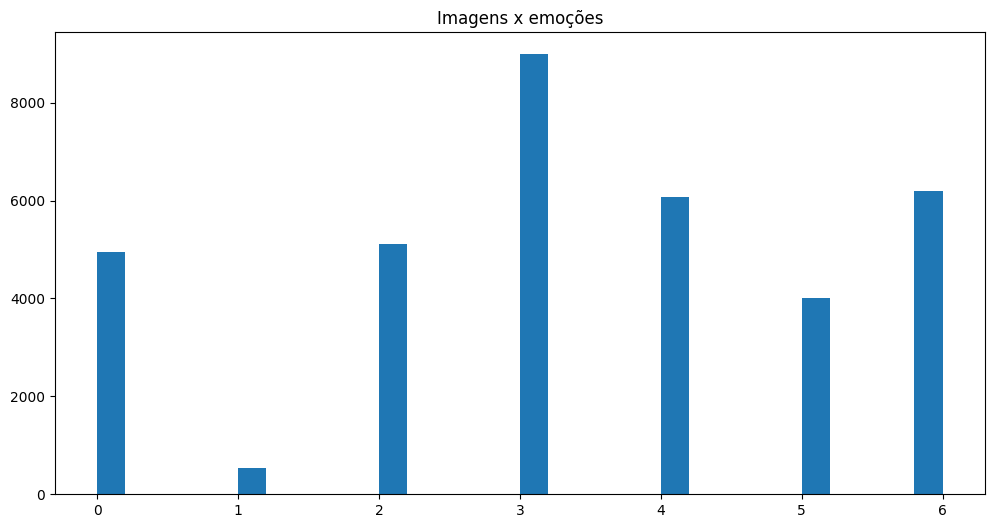

In [11]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 30)
plt.title('Images x emotions')

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Step 4 - Pre-processing

In [12]:
pixels = data['pixels'].tolist()
pixels

Output hidden; open in https://colab.research.google.com to view.

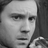

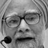

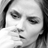

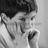

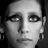

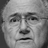

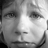

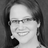

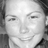

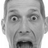

In [13]:
largura, altura = 48, 48
faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)
  amostras += 1

In [14]:
print('Número total de imagens no dataset: ', str(len(faces)))

Número total de imagens no dataset:  35887


In [15]:
faces = np.asarray(faces)

In [16]:
faces.shape

(35887, 48, 48)

In [17]:
faces = np.expand_dims(faces, -1)
faces.shape

(35887, 48, 48, 1)

In [18]:
def normalizar(x):
  x = x.astype('float32')
  x = x / 255.0
  return x

In [19]:
faces = normalizar(faces)

In [20]:
faces[0]

array([[[0.27450982],
        [0.3137255 ],
        [0.32156864],
        ...,
        [0.20392157],
        [0.16862746],
        [0.16078432]],

       [[0.25490198],
        [0.23921569],
        [0.22745098],
        ...,
        [0.21960784],
        [0.20392157],
        [0.17254902]],

       [[0.19607843],
        [0.16862746],
        [0.21176471],
        ...,
        [0.19215687],
        [0.21960784],
        [0.18431373]],

       ...,

       [[0.35686275],
        [0.25490198],
        [0.16470589],
        ...,
        [0.28235295],
        [0.21960784],
        [0.16862746]],

       [[0.3019608 ],
        [0.32156864],
        [0.30980393],
        ...,
        [0.4117647 ],
        [0.27450982],
        [0.18039216]],

       [[0.3019608 ],
        [0.28235295],
        [0.32941177],
        ...,
        [0.41568628],
        [0.42745098],
        [0.32156864]]], dtype=float32)

In [21]:
emocoes = pd.get_dummies(data['emotion']).values

In [22]:
emocoes[0]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Step 5 - Imports from Tensorflow/Keras

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Step 6 - Split into sets for training and validation

In [24]:
X_train, X_test, y_train, y_test = train_test_split(faces, emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [25]:
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de teste: 3589
Número de imagens no conjunto de validação: 3230


In [26]:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

## Step 7 - Model Architecture (CNN)

### Model architecture 1

Padding same x valid: https://www.corvil.com/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

Original implementation: https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280

Regularizers: https://keras.io/regularizers/

Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [27]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

## Step 8 - Compiling the model

Parâmetros Adam: https://arxiv.org/abs/1412.6980

Artigo Adam: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

beta: Taxa de decaimento exponencial (por exemplo, 0.9)

In [28]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.h5'
arquivo_modelo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

### Saving the model architecture to a JSON file

In [29]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

## Step 9 - Training the model

In [30]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 1.9885 - accuracy: 0.2144
Epoch 1: val_loss improved from inf to 1.82750, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 39s 58ms/step - loss: 1.9885 - accuracy: 0.2144 - val_loss: 1.8275 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


454/455 [============================>.] - ETA: 0s - loss: 1.8398 - accuracy: 0.2441
Epoch 2: val_loss improved from 1.82750 to 1.82337, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 25s 55ms/step - loss: 1.8398 - accuracy: 0.2442 - val_loss: 1.8234 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 1.7988 - accuracy: 0.2629
Epoch 3: val_loss did not improve from 1.82337
455/455 [==============================] - 25s 55ms/step - loss: 1.7988 - accuracy: 0.2629 - val_loss: 1.8325 - val_accuracy: 0.2601 - lr: 0.0010
Epoch 4/100
454/455 [============================>.] - ETA: 0s - loss: 1.7141 - accuracy: 0.3112
Epoch 4: val_loss improved from 1.82337 to 1.55963, saving model to modelo_01_expressoes.h5
455/455 [==============================] - 26s 56ms/step - loss: 1.7141 - accuracy: 0.3112 - val_loss: 1.5596 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 5/100
454/455 [============================>.]

In [31]:
print(history.history)

{'loss': [1.9885032176971436, 1.8397678136825562, 1.798836350440979, 1.7140815258026123, 1.605088710784912, 1.5223332643508911, 1.455736517906189, 1.4063363075256348, 1.3760313987731934, 1.3351752758026123, 1.3028762340545654, 1.2819890975952148, 1.2564910650253296, 1.2387791872024536, 1.2029134035110474, 1.1891915798187256, 1.1612106561660767, 1.1377003192901611, 1.11397385597229, 1.0878283977508545, 1.0736955404281616, 1.0532172918319702, 1.023429036140442, 0.9981434941291809, 0.9728547930717468, 0.9519094824790955, 0.9396689534187317, 0.919838547706604, 0.8969959020614624, 0.8792919516563416, 0.8760979175567627, 0.8518292307853699, 0.8343235850334167, 0.8098294138908386, 0.7918190360069275, 0.7632017731666565, 0.7423256039619446], 'accuracy': [0.21439383924007416, 0.24418604373931885, 0.26293519139289856, 0.311166912317276, 0.36645108461380005, 0.40336453914642334, 0.4405531883239746, 0.46367138624191284, 0.47622814774513245, 0.49339479207992554, 0.5047130584716797, 0.52098530530929

## Generating graph of improvement at each stage of training

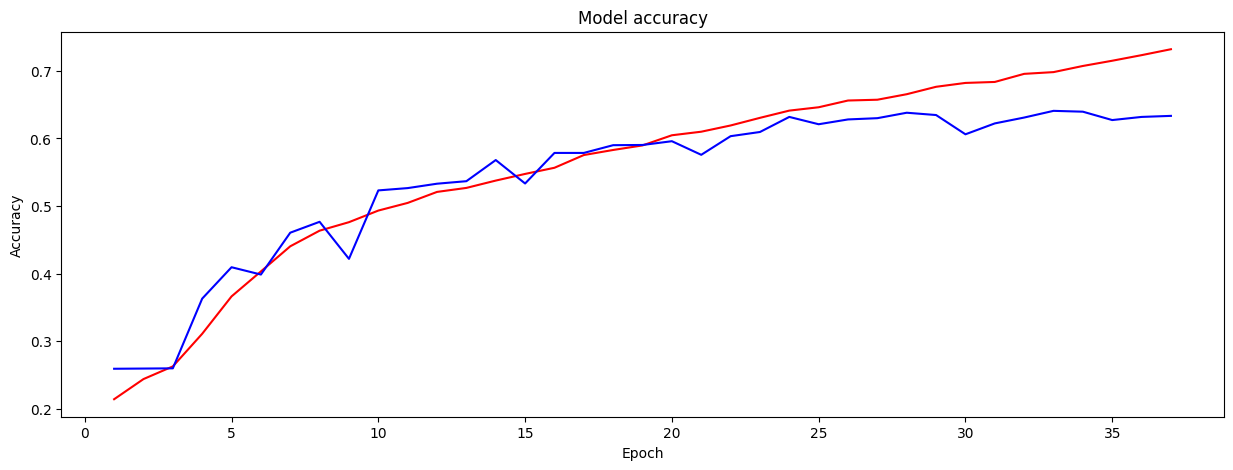

In [66]:
import matplotlib.pyplot as plt

def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1, 1, figsize=(15,5))  # alteração aqui
    axs.plot(range(1, len(historico_modelo.history['accuracy']) + 1), historico_modelo.history['accuracy'], 'r')
    axs.plot(range(1, len(historico_modelo.history['val_accuracy']) + 1), historico_modelo.history['val_accuracy'], 'b')
    axs.set_title('Model accuracy')
    axs.set_ylabel('Accuracy')
    axs.set_xlabel('Epoch')
    plt.show()

plota_historico_modelo(history)


### Checking model accuracy

In [34]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)

57/57 [==============================] - 1s 22ms/step - loss: 1.1262 - accuracy: 0.6183


In [35]:
scores

[1.126175045967102, 0.6182780861854553]

In [36]:
print('Acurácia: ' + str(scores[1]))
print('Erro: ' + str(scores[0]))

Acurácia: 0.6182780861854553
Erro: 1.126175045967102


## Loading data to generate the confusion matrix

In [37]:
true_y = []
pred_y = []
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

In [38]:
x[0]

array([[[0.5568628 ],
        [0.5803922 ],
        [0.59607846],
        ...,
        [0.3529412 ],
        [0.3529412 ],
        [0.3647059 ]],

       [[0.5568628 ],
        [0.5764706 ],
        [0.5921569 ],
        ...,
        [0.33333334],
        [0.36078432],
        [0.40392157]],

       [[0.5529412 ],
        [0.5686275 ],
        [0.5921569 ],
        ...,
        [0.3372549 ],
        [0.32156864],
        [0.37254903]],

       ...,

       [[0.0627451 ],
        [0.08235294],
        [0.07058824],
        ...,
        [0.08235294],
        [0.09019608],
        [0.11372549]],

       [[0.05490196],
        [0.0627451 ],
        [0.05490196],
        ...,
        [0.07450981],
        [0.07843138],
        [0.09803922]],

       [[0.04705882],
        [0.04705882],
        [0.04705882],
        ...,
        [0.06666667],
        [0.07450981],
        [0.09411765]]], dtype=float32)

In [39]:
y[0]

array([0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [40]:
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [41]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)

In [42]:
y_pred = loaded_model.predict(x)

113/113 [==============================] - 2s 6ms/step


In [43]:
y_pred[0]

array([1.2355243e-03, 2.4765700e-07, 8.8830628e-03, 9.2250711e-01,
       2.6181806e-03, 4.5805439e-02, 1.8950466e-02], dtype=float32)

In [44]:
yp = y_pred.tolist()
yt = y.tolist()
count = 0

In [45]:
len(y)

3589

In [46]:
for i in range(len(y)):
  yy = max(yp[i])
  yyt = max(yt[i])
  pred_y.append(yp[i].index(yy))
  true_y.append(yt[i].index(yyt))
  if (yp[i].index(yy) == yt[i].index(yyt)):
    count += 1

acc = (count / len(y)) * 100

In [47]:
print('Acurácia no conjunto de teste: ' + str(acc))

Acurácia no conjunto de teste: 61.6049038729451


In [48]:
np.save('truey_mod01', true_y)
np.save('predy_mod01', pred_y)

## Gerando a Matriz de Confusão

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
y_true = np.load('truey_mod01.npy')
y_pred = np.load('predy_mod01.npy')

In [67]:
cm = confusion_matrix(y_true, y_pred)
expressoes = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']
titulo = 'Confusion Matrix'
print(cm)

[[248   5  24  24  90  11  96]
 [ 19  21   4   3   2   1   2]
 [ 62   8 155  30 154  59  77]
 [ 20   0   7 752  30  24  48]
 [ 53   0  26  34 308   0 167]
 [  7   0  44  28  12 298  25]
 [ 20   1  11  50  96   4 429]]


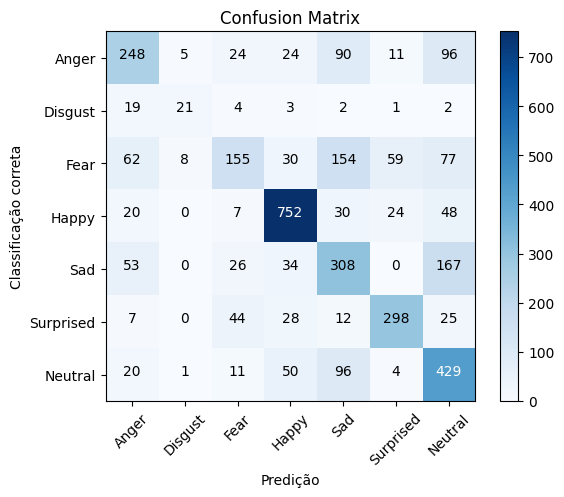

In [68]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation = 45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')

plt.ylabel('Classificação correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')

## Testing the model

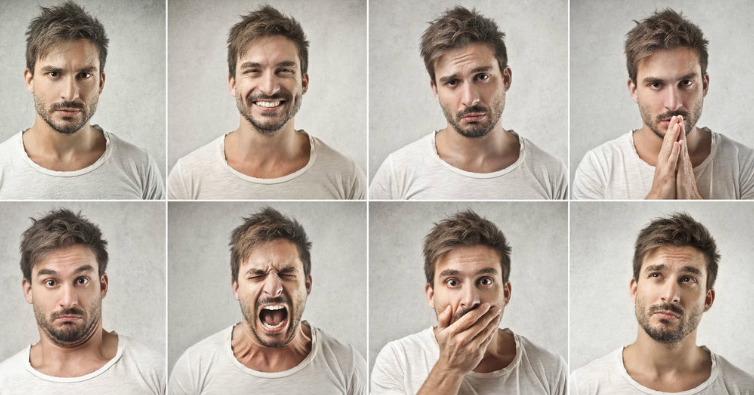

In [69]:
imagem = cv2.imread('Material/testes/teste02.jpg')
cv2_imshow(imagem)

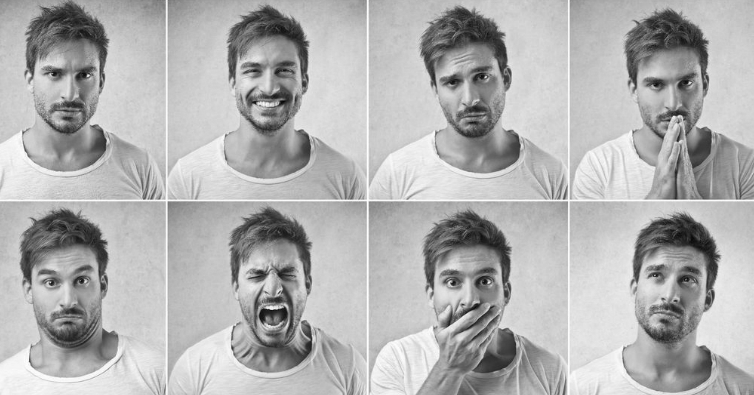

In [70]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [71]:
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

In [72]:
faces

array([[224,  35,  90,  90],
       [ 23,  41,  92,  92],
       [625,  49,  91,  91],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

1/1 [==============================] - 0s 16ms/step


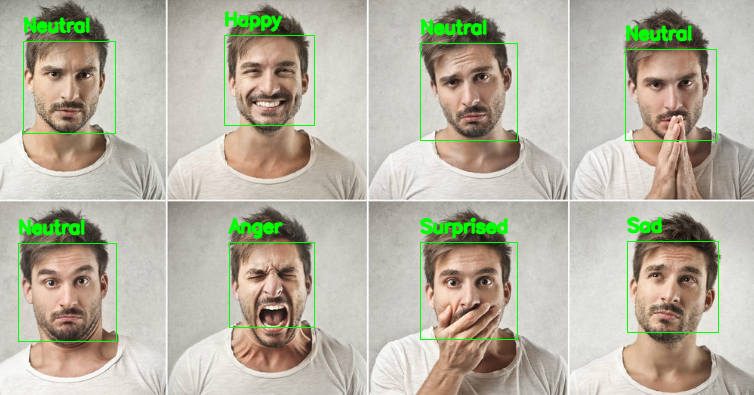

In [73]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)

